In [5]:
import os
import math
import random

OPENSLIDE_PATH = r'D:\Openslide\Openslide\openslide-win64-20231011\bin'

with os.add_dll_directory(OPENSLIDE_PATH):
    import openslide
    
import numpy as np


class CropList:
    """
    The class CropList implements a type which behaves like a python list, but reads data from disk only when required.
    This allows the usage of large WSI without being constrained by the amount of available memory.
    """
    def __init__(self, indexes, size=None):
        self.indexes = indexes
        self.size = size

    def __add__(self, b):
        return CropList(self.indexes + b.indexes)

    def __len__(self):
        return len(self.indexes)

    def __getitem__(self, idx):
        section = self.indexes[idx]
        region = openslide.OpenSlide(
            section['filepath_slide']).read_region([section['left'],
                                                    section['top']],
                                                   section['level'],
                                                   [section['size'],
                                                    section['size']])
        region = region.convert('RGB')
        region = region.resize(size=(self.size, self.size))
        return np.array(region)

    def shuffle(self):
        random.shuffle(self.indexes)


class SectionManager:
    def __init__(self, crop_size, overlap=1):
        """
        # SectionManager provides an easy way to generate a cropList object.
        # This object is not tied to a particular slide and can be reused to crop many slides using the same settings.
        @param crop_size: crop_size
        @param overlap: overlap (%)
        """
        self.defaultSide = crop_size
        self.level = 0
        self.overlap = int(1/overlap)

    def __generateSections__(self,
                             x_start,
                             y_start,
                             width,
                             height,
                             downsample,
                             side=None):
        if side is None:
            side = self.defaultSide

        step = int(side / self.overlap)
        self.__sections__ = []

        n_crops = 0
        print('_'*15)
        print("STEP: {}".format(step))
        print("Y: {}".format(y_start))
        print("X: {}".format(x_start))
        print("W {}".format(width))
        print("H {}".format(height))
        print("DOWNSAMPLE: {}".format(downsample))

        # N.B. Crops are considered in the 0 level
        for y in range(int(math.floor(height / step))):
            for x in range(int(math.floor(width / step))):
                # x * step + side is right margin of the given crop
                if x * step + side > width or y * step + side > height:
                    continue
                n_crops += 1
                self.__sections__.append(
                    {'top': y_start + step * y, 'left': x_start + step * x, 'size': math.floor(side / downsample),
                     'augmented': False})
        print("{} CROPS".format(n_crops))
        print('_'*15)

    def crop(self, filepath_slide, slide_label=None, size=None, save_dir=None):
        self.level = 0
        slide = openslide.OpenSlide(filepath_slide)
        downsample = slide.level_downsamples[self.level]
        if 'openslide.bounds-width' in slide.properties.keys():
            bounds_width = int(slide.properties['openslide.bounds-width'])
            bounds_height = int(slide.properties['openslide.bounds-height'])
            bounds_x = int(slide.properties['openslide.bounds-x'])
            bounds_y = int(slide.properties['openslide.bounds-y'])
        else:
            print("{} - no bounds".format(filepath_slide))
            bounds_width = slide.dimensions[0]
            bounds_height = slide.dimensions[1]
            bounds_x = 0
            bounds_y = 0
        if save_dir:
            pim = slide.read_region((int(bounds_x),
                                     int(bounds_y)),
                                    slide.level_count - 1,
                                    (int(bounds_width/slide.level_downsamples[-1]),
                                     int(bounds_height/slide.level_downsamples[-1])))
            basename = os.path.basename(filepath_slide)
            pim.save(os.path.join(save_dir, basename + '.png'))

        self.__generateSections__(bounds_x,
                                  bounds_y,
                                  bounds_width,
                                  bounds_height,
                                  downsample)
        indexes = self.__sections__
        for index in indexes:
            index['filepath_slide'] = filepath_slide
            index['level'] = self.level
            index['slide_label'] = slide_label
        return CropList(indexes, size=size)


In [6]:
crop_size = 1000  # Example crop size
overlap = 1  # No overlap in this example
section_manager = SectionManager(crop_size, overlap)

filepath_slide = "F:\My Files\Thesis\Dataset\RCC_WSIs\ccRCC/H19.754.IHC.ccRCC.scn"  # Path to the WSI file
slide_label = "example_label"  # Optional label for the slide
save_dir = "example/"  # Optional directory to save a slide preview
size = 112  # Desired size to resize the patches

crop_list = section_manager.crop(filepath_slide, slide_label, size, save_dir)



_______________
STEP: 1000
Y: 132286
X: 35745
W 55809
H 56833
DOWNSAMPLE: 1.0
3080 CROPS
_______________


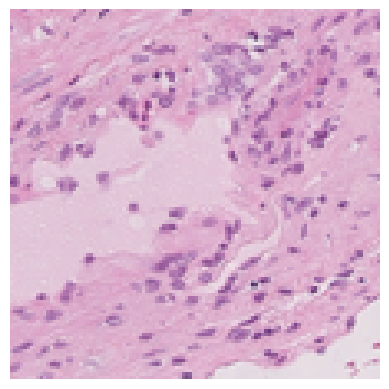

In [11]:
import matplotlib.pyplot as plt

# Assuming 'patch' is a numpy array representing an image patch
# You can obtain a patch from the CropList like so: patch = crop_list[0]

def plot_patch(patch):
    plt.imshow(patch)
    plt.axis('off')  # Remove axis ticks and labels
    plt.show()


patch = crop_list[250]  # Access the first patch

# If your data is not uint8 but should be, convert it
if patch.dtype != np.uint8:
    patch = (255 * (patch - patch.min()) / (patch.max() - patch.min())).astype(np.uint8)

plot_patch(patch)

## Annotation Manager

In [4]:
import os
import math
import random
import xml.etree.ElementTree as ET
from shapely.geometry import Polygon, Point

OPENSLIDE_PATH = r'D:\Openslide\Openslide\openslide-win64-20231011\bin'

with os.add_dll_directory(OPENSLIDE_PATH):
    import openslide
    
import numpy as np

    
def patch_label(patch_coordinates, annotations):
    patch_x, patch_y, patch_size = patch_coordinates
    patch_polygon = Polygon([(patch_x, patch_y), 
                            (patch_x + patch_size, patch_y), 
                            (patch_x + patch_size, patch_y + patch_size), 
                            (patch_x, patch_y + patch_size)])
    
    for annotation in annotations:
        annotation_polygon = Polygon(annotation['points'])
        if patch_polygon.intersects(annotation_polygon):
            return annotation['part_of_group']
    
    return None


class CropList:
    """
    The class CropList implements a type which behaves like a python list, but reads data from disk only when required.
    This allows the usage of large WSI without being constrained by the amount of available memory.
    """
    def __init__(self, indexes, size=None):
        self.indexes = indexes
        self.size = size

    def __add__(self, b):
        return CropList(self.indexes + b.indexes)

    def __len__(self):
        return len(self.indexes)

    def __getitem__(self, idx):
        section = self.indexes[idx]
        region = openslide.OpenSlide(
            section['filepath_slide']).read_region([section['left'],
                                                    section['top']],
                                                   section['level'],
                                                   [section['size'],
                                                    section['size']])
        region = region.convert('RGB')
        label = section['label']
        region = region.resize(size=(self.size, self.size))
        return np.array(region), label

    def shuffle(self):
        random.shuffle(self.indexes)


class SectionManager:
    def __init__(self, crop_size, annot_path, overlap=1):
        """
        # SectionManager provides an easy way to generate a cropList object.
        # This object is not tied to a particular slide and can be reused to crop many slides using the same settings.
        @param crop_size: crop_size
        @param overlap: overlap (%)
        """
        self.defaultSide = crop_size
        self.level = 0
        self.overlap = int(1/overlap)
        self.annot_path = annot_path
        self.parse_annotations()

    def parse_annotations(self):

        if self.annoth_path==None
        tree = ET.parse(self.annot_path)
        root = tree.getroot()
        self.annotations = []

        for annotation in root.find('Annotations'):
            points = []
            part_of_group = annotation.attrib['PartOfGroup']
            for coordinate in annotation.find('Coordinates'):
                x = float(coordinate.attrib['X'])
                y = float(coordinate.attrib['Y'])
                points.append((x, y))

            self.annotations.append({'part_of_group': part_of_group, 'points': points})

        return self.annotations
    
    def patch_label(self, patch_coordinates):
        patch_x, patch_y, patch_size = patch_coordinates

        tile_bbox = Polygon(
            [(patch_x, patch_y), (patch_x + patch_size, patch_y), (patch_x + patch_size, patch_y + patch_size), (patch_x, patch_y + patch_size)]
        )

        labels = []
        for annotation in self.annotations:
            annotation_polygon = Polygon(annotation['points'])
            if tile_bbox.intersects(annotation_polygon):  # Check if the center is within the polygon
                labels.append(annotation['part_of_group'])

        return labels

    def __generateSections__(self,
                             x_start,
                             y_start,
                             width,
                             height,
                             downsample,
                             side=None):
        if side is None:
            side = self.defaultSide

        step = int(side / self.overlap)
        self.__sections__ = []

        n_crops = 0
        print('_'*15)
        print("STEP: {}".format(step))
        print("Y: {}".format(y_start))
        print("X: {}".format(x_start))
        print("W {}".format(width))
        print("H {}".format(height))
        print("DOWNSAMPLE: {}".format(downsample))

        # N.B. Crops are considered in the 0 level
        for y in range(int(math.floor(height / step))):
            for x in range(int(math.floor(width / step))):
                # x * step + side is right margin of the given crop
                if x * step + side > width or y * step + side > height:
                    continue
                n_crops += 1
                label = self.patch_label(patch_coordinates=(x_start + step * x, y_start + step * y, math.floor(side / downsample)))
                self.__sections__.append(
                    {'top': y_start + step * y, 'left': x_start + step * x, 'size': math.floor(side / downsample),
                     'augmented': False, 'label':label})
        print("{} CROPS".format(n_crops))
        print('_'*15)

    def crop(self, filepath_slide, slide_label=None, size=None, save_dir=None):
        self.level = 0
        slide = openslide.OpenSlide(filepath_slide)
        downsample = slide.level_downsamples[self.level]
        if 'openslide.bounds-width' in slide.properties.keys():
            bounds_width = int(slide.properties['openslide.bounds-width'])
            bounds_height = int(slide.properties['openslide.bounds-height'])
            bounds_x = int(slide.properties['openslide.bounds-x'])
            bounds_y = int(slide.properties['openslide.bounds-y'])
        else:
            print("{} - no bounds".format(filepath_slide))
            bounds_width = slide.dimensions[0]
            bounds_height = slide.dimensions[1]
            bounds_x = 0
            bounds_y = 0
        if save_dir:
            pim = slide.read_region((int(bounds_x),
                                     int(bounds_y)),
                                    slide.level_count - 1,
                                    (int(bounds_width/slide.level_downsamples[-1]),
                                     int(bounds_height/slide.level_downsamples[-1])))
            basename = os.path.basename(filepath_slide)
            pim.save(os.path.join(save_dir, basename + '.png'))

        self.__generateSections__(bounds_x,
                                  bounds_y,
                                  bounds_width,
                                  bounds_height,
                                  downsample)
        indexes = self.__sections__
        for index in indexes:
            index['filepath_slide'] = filepath_slide
            index['level'] = self.level
            index['slide_label'] = slide_label

        return CropList(indexes=indexes, size=size)

In [10]:
filepath_slide = "F:\My Files\Thesis\Dataset\RCC_WSIs\ccRCC/H19.754.IHC.ccRCC.scn"  # Path to the WSI file
xml_path = "F:\My Files\Thesis\Dataset\RCC_WSIs\ccRCC\ccRCC_xml\H19.754.IHC.ccRCC.xml"  # Update with the path to your XML file
slide_label = "example_label"  # Optional label for the slide
save_dir = "example/"  # Optional directory to save a slide preview
crop_size = 1000  # Example crop size in pixels
overlap = 1  # Example overlap; use 1 for no overlap, 2 for 50% overlap, etc.
size = 112  # Desired size to resize the patches

section_manager = SectionManager(crop_size, xml_path, overlap)

# Generate CropList with annotations
crop_list = section_manager.crop(filepath_slide=filepath_slide, size=size)

_______________
STEP: 1000
Y: 132286
X: 35745
W 55809
H 56833
DOWNSAMPLE: 1.0
3080 CROPS
_______________


In [14]:
import matplotlib.pyplot as plt

# Assuming 'patch' is a numpy array representing an image patch
# You can obtain a patch from the CropList like so: patch = crop_list[0]

def plot_patch(patch):
    plt.imshow(patch)
    plt.axis('off')  # Remove axis ticks and labels
    plt.show()

dist = {
    'necrosis': 0,
    'fiber': 0,
    'tumor': 0
}

for i in range(len(crop_list)):
    
    patch, label = crop_list[i]
    
    if label:
        dist[label[0]] += 1
    

In [15]:
dist

{'necrosis': 17, 'fiber': 242, 'tumor': 49}

In [4]:
import os

OPENSLIDE_PATH = r'D:\Openslide\Openslide\openslide-win64-20231011\bin'

with os.add_dll_directory(OPENSLIDE_PATH):
    import openslide

def calculate_total_patches(slide_dimensions, patch_size):
    width, height = slide_dimensions
    num_patches_x = width // patch_size + (1 if width % patch_size != 0 else 0)
    num_patches_y = height // patch_size + (1 if height % patch_size != 0 else 0)
    return num_patches_x * num_patches_y

def extract_and_resize_patches(slide_path, level=0, patch_size=1000, new_size=112):
    slide = openslide.OpenSlide(slide_path)
    slide_name = os.path.splitext(os.path.basename(slide_path))[0]
    
    width, height = slide.dimensions
    total_patches = calculate_total_patches((width, height), patch_size)
    print(f"Total number of patches: {total_patches}")
    
    for x in range(0, width, patch_size):
        for y in range(0, height, patch_size):
            patch = slide.read_region((x, y), level, (patch_size, patch_size))
            patch = patch.convert("RGB")
            resized_patch = patch.resize(size=(new_size, new_size))
            
            # Adjusted file naming convention
            filename = f"{slide_name}_{x}_{y}_{level}_{patch_size}.png"
            resized_patch.save(filename)
            break
        break

# Example usage
slide_path = "F:\My Files\Thesis\Dataset\RCC_WSIs\ccRCC/H19.754.IHC.ccRCC.scn"
extract_and_resize_patches(slide_path)

Total number of patches: 32849


## Read Data Loop

In [7]:
import os

OPENSLIDE_PATH = r'D:\Openslide\Openslide\openslide-win64-20231011\bin'

with os.add_dll_directory(OPENSLIDE_PATH):
    import openslide

class CropList:
    """
    The class CropList implements a type which behaves like a python list, but reads data from disk only when required.
    This allows the usage of large WSI without being constrained by the amount of available memory.
    """
    def __init__(self, indexes, size=None):
        self.indexes = indexes
        self.size = size

    def __add__(self, b):
        return CropList(self.indexes + b.indexes)

    def __len__(self):
        return len(self.indexes)

    def __getitem__(self, idx):
        section = self.indexes[idx]
        region = openslide.OpenSlide(
            section['filepath_slide']).read_region([section['left'],
                                                    section['top']],
                                                   section['level'],
                                                   [section['size'],
                                                    section['size']])
        region = region.convert('RGB')
        region = region.resize(size=(self.size, self.size))
        return np.array(region)

    def shuffle(self):
        random.shuffle(self.indexes)
    
class CropIndexer:
    def __init__(self, crop_size, overlap=1):
        """
        # SectionManager provides an easy way to generate a cropList object.
        # This object is not tied to a particular slide and can be reused to crop many slides using the same settings.
        @param crop_size: crop_size
        @param overlap: overlap (%)
        """
        self.defaultSide = crop_size
        self.level = 0
        self.overlap = int(1/overlap)

    def crop(self, filepath_slide):
        self.level = 0
        slide = openslide.OpenSlide(filepath_slide)
        downsample = slide.level_downsamples[self.level]
        if 'openslide.bounds-width' in slide.properties.keys():
            bounds_width = int(slide.properties['openslide.bounds-width'])
            bounds_height = int(slide.properties['openslide.bounds-height'])
            bounds_x = int(slide.properties['openslide.bounds-x'])
            bounds_y = int(slide.properties['openslide.bounds-y'])
        else:
            print("{} - No Bounds".format(filepath_slide))
            bounds_width = slide.dimensions[0]
            bounds_height = slide.dimensions[1]
            bounds_x = 0
            bounds_y = 0

        step = int(self.defaultSide / self.overlap)
        self.sections = []

        # N.B. Crops are considered in the 0 level
        for y in range(int(math.floor(bounds_height / step))):
            for x in range(int(math.floor(bounds_width / step))):
                # x * step + side is right margin of the given crop
                if x * step + self.defaultSide > bounds_width or y * step + self.defaultSide > bounds_height:
                    continue
                self.sections.append(
                    {'Top': bounds_y + step * y, 'Left': bounds_x + step * x, 'Size': math.floor(self.defaultSide / downsample),
                     'Augmented': False})
                
        return list(self.sections)

def _is_background(image_array):
    # White crops are removed at runtime.
    mean = np.mean(image_array)

    if mean > 210:
        return True
    else:
        return False

In [11]:
import os
import pandas as pd
import numpy as np
import math
    
PRE_PATH = 'pre'
ROOT_PATH = "F:\\My Files\\Thesis\\Dataset\\RCC_WSIs"
IDS_PATH = "E:\\Dropbox (Politecnico Di Torino Studenti)\\Courses\\Thesis\\Code\\ExpertDT\\ExpertDT\\_ids"
DF_NAME = "RCC_DF"

crop_size = 1000  # Example crop size in pixels
level = 0
overlap = 1  # Example overlap; use 1 for no overlap, 2 for 50% overlap, etc.
crop_resize = 112  # Desired size to resize the patches

WSI_FORMATS = ['scn', 'svs', 'tif']

# subtypes_list = [('ccRCC', 'xml'), ('pRCC', 'xml'), ('CHROMO', 'slide'), ('ONCOCYTOMA', 'slide')]
subtypes_list = [('ccRCC', 'xml')]

subtypes_pre = {'ccRCC':True, 'pRCC':True, 'CHROMO':False, 'ONCOCYTOMA':False}

subtype_no_roi = {}
subtype_roi_id = {}

data_list = []

for subtype in subtypes_list:
    if subtype[1]=='slide':
        patients_ids = f'{IDS_PATH}\\data_ids_{subtype[0]}.txt'
        with open(patients_ids, 'r') as file:
            patient_list = [line.strip() for line in file]

        patient_corr_path = f'{ROOT_PATH}\\{subtype[0]}\\Annotations_{subtype[0]}\\{subtype[0]}_patients_correspondence.xlsx'

        subtype_roi_id[subtype[0]] = {}

        # Read patience correspondence file for subtype
        patients_corr = pd.read_excel(patient_corr_path)

        # Loop over patient annotation files number
        for i in range(patients_corr.shape[0]):
            annot_slide_no = patients_corr.iloc[i]['ID'].split('-')

            # Check if one slide has more than 1 annotation file
            if len(annot_slide_no)>1:
                subtype_roi_id[subtype[0]][patients_corr.iloc[i]['PATIENT']] = list(str(i) for i in range(int(annot_slide_no[0]), int(annot_slide_no[1])+1))
            else:
                subtype_roi_id[subtype[0]][patients_corr.iloc[i]['PATIENT']] = annot_slide_no

        # List of No ROI Patients to be considered as test set later        
        patients_list_annot = patients_corr.iloc[:, 1].tolist()
        subtype_no_roi[subtype[0]] = list(set(patient_list) - set(patients_list_annot))

        for patient in subtype_roi_id[subtype[0]]:
            for roi in subtype_roi_id[subtype[0]][patient]:

                new_data_dict = {"Subtype":None, "PatientID":None, "Filepath":None,
                                "Tumorous":None, "Type":None, "Top":None, "Left":None,
                                "Side":None, "Augmented":None}
                
                slide_section = CropIndexer(crop_size=crop_size, overlap=1)
                for fmt in WSI_FORMATS:
                    slide_directory = f'{ROOT_PATH}\\{subtype[0]}\\Annotations_{subtype[0]}\\{roi}.{fmt}'
                    if os.path.exists(slide_directory):
                        indexes = slide_section.crop(filepath_slide=slide_directory)
                        break

                temp_data = {}
                for index in indexes:

                    temp_data['Subtype'] = subtype[0]
                    temp_data['PatientID'] = patient
                    temp_data['Filepath'] = slide_directory
                    temp_data['Tumorous'] = True
                    temp_data['Type'] = subtype[0]
                    temp_data['Top'] = index['Top']
                    temp_data['Left'] = index['Left']
                    temp_data['Size'] = index['Size']
                    data_list.append(temp_data)

    elif subtype[1]=='xml':

        patients_ids = f'{IDS_PATH}\\data_ids_{subtype[0]}.txt'
        subtype_path = os.path.join(ROOT_PATH, subtype[0])
        subtype_files = os.listdir(subtype_path)
        with open(patients_ids, 'r') as file:
            patient_list = [line.strip() for line in file]

        i = 0
        files = [f for f in os.listdir(f"{ROOT_PATH}\\{subtype[0]}") if os.path.isfile(os.path.join(f"{ROOT_PATH}\\{subtype[0]}", f))]
        for patient in patient_list:
            i += 1
            print(patient)
            patient_files_list = []
            for file in subtype_files:
                if patient in file:
                    patient_files_list.append(file)

            for slide_dir in patient_files_list:
    
            print(patient_files_list)
            print('---------------------------------------------------')

        print(i)
        
        # for patient in patient_list:
            
        #     if patient not in subtype_files:
        #         print(patient)
        #     else:
        #         print(f"KIR {patient}")
            
        # subtype_path = os.path.join(ROOT_PATH, subtype[0])
        # subtype_files = os.listdir(subtype_path)
        # for file in subtype_files:
        #     if file.split('.')[-1] in WSI_FORMATS:
        #         slide_name = file[:-4]
        #         slide_format = file[-3:]
                
# data_df = pd.DataFrame(data_list)


HP1213588
[]
---------------------------------------------------
HP123187
[]
---------------------------------------------------
HP131799
[]
---------------------------------------------------
HP145590
[]
---------------------------------------------------
HP193695
[]
---------------------------------------------------
HP195524
[]
---------------------------------------------------
HP197949
[]
---------------------------------------------------
H19.754
['H19.754.IHC.ccRCC.scn']
---------------------------------------------------
HP02.10180
[]
---------------------------------------------------
HP10.2695
[]
---------------------------------------------------
HP10.2986
[]
---------------------------------------------------
HP10.5813
[]
---------------------------------------------------
HP11.12277
[]
---------------------------------------------------
HP11.12318
[]
---------------------------------------------------
HP12.13358
[]
---------------------------------------------------
HP12.3

In [85]:
data_df

,Subtype,PatientID,Filepath,Tumorous,Type,Top,Left,Size
0,CHROMO,HP17008718,F:\My Files\Thesis\Dataset\RCC_WSIs\CHROMO\Ann...,True,CHROMO,16000,11000,1000
1,CHROMO,HP17008718,F:\My Files\Thesis\Dataset\RCC_WSIs\CHROMO\Ann...,True,CHROMO,16000,11000,1000
2,CHROMO,HP17008718,F:\My Files\Thesis\Dataset\RCC_WSIs\CHROMO\Ann...,True,CHROMO,16000,11000,1000
3,CHROMO,HP17008718,F:\My Files\Thesis\Dataset\RCC_WSIs\CHROMO\Ann...,True,CHROMO,16000,11000,1000
4,CHROMO,HP17008718,F:\My Files\Thesis\Dataset\RCC_WSIs\CHROMO\Ann...,True,CHROMO,16000,11000,1000
...,...,...,...,...,...,...,...,...
7703,CHROMO,HP20.2506,F:\My Files\Thesis\Dataset\RCC_WSIs\CHROMO\Ann...,True,CHROMO,21000,29000,1000
7704,CHROMO,HP20.2506,F:\My Files\Thesis\Dataset\RCC_WSIs\CHROMO\Ann...,True,CHROMO,21000,29000,1000
7705,CHROMO,HP20.2506,F:\My Files\Thesis\Dataset\RCC_WSIs\CHROMO\Ann...,True,CHROMO,21000,29000,1000
7706,CHROMO,HP20.2506,F:\My Files\Thesis\Dataset\RCC_WSIs\CHROMO\Ann...,True,CHROMO,21000,29000,1000


In [47]:
for key in subtype_roi_id['CHROMO']:
    print(key)

HP17008718
HP20002300
HP18014084
HP19012316
HP20.2506


In [52]:
directory_path = f'{ROOT_PATH}\\CHROMO\\Annotations_CHROMO\\1.svs'

# Check if the directory exists
if os.path.exists(directory_path):
    print(f"The directory '{directory_path}' exists.")

The directory 'F:\My Files\Thesis\Dataset\RCC_WSIs\CHROMO\Annotations_CHROMO\1.svs' exists.


In [39]:
data.loc[0, 'X'] = 2

In [40]:
data

,X
0,2.0


In [26]:
for i in range(patients_corr.shape[0]):
    print(patients_corr.iloc[i]['ID'].split('-'))


['1', '2']
['3', '7']
['8']
['9', '11']
['12', '13']


In [4]:
import pandas as pd

subtype = 'CHROMO'
file_path = f'F:\\My Files\\Thesis\Dataset\\RCC_WSIs\\CHROMO\\Annotations_CHROMO\\{subtype}_patients_correspondence.xlsx'
df = pd.read_excel(file_path)
second_column = df.iloc[:, 1].tolist()
print(second_column)

['HP17008718', 'HP20002300', 'HP18014084', 'HP19012316', 'HP20.2506']


In [ ]:
import os
import math
import random
import xml.etree.ElementTree as ET
from shapely.geometry import Polygon

OPENSLIDE_PATH = r'D:\Openslide\Openslide\openslide-win64-20231011\bin'

with os.add_dll_directory(OPENSLIDE_PATH):
    import openslide
    
import numpy as np

    
def patch_label(patch_coordinates, annotations):
    patch_x, patch_y, patch_size = patch_coordinates
    patch_polygon = Polygon([(patch_x, patch_y), 
                            (patch_x + patch_size, patch_y), 
                            (patch_x + patch_size, patch_y + patch_size), 
                            (patch_x, patch_y + patch_size)])
    
    for annotation in annotations:
        annotation_polygon = Polygon(annotation['points'])
        if patch_polygon.intersects(annotation_polygon):
            return annotation['part_of_group']
    
    return None


class CropList:
    """
    The class CropList implements a type which behaves like a python list, but reads data from disk only when required.
    This allows the usage of large WSI without being constrained by the amount of available memory.
    """
    def __init__(self, indexes, size=None):
        self.indexes = indexes
        self.size = size

    def __add__(self, b):
        return CropList(self.indexes + b.indexes)

    def __len__(self):
        return len(self.indexes)

    def __getitem__(self, idx):
        section = self.indexes[idx]
        region = openslide.OpenSlide(
            section['filepath_slide']).read_region([section['left'],
                                                    section['top']],
                                                   section['level'],
                                                   [section['size'],
                                                    section['size']])
        region = region.convert('RGB')
        label = section['label']
        region = region.resize(size=(self.size, self.size))
        return np.array(region), label

    def shuffle(self):
        random.shuffle(self.indexes)


class SectionManager:
    def __init__(self, crop_size, annot_path, overlap=1):
        """
        # SectionManager provides an easy way to generate a cropList object.
        # This object is not tied to a particular slide and can be reused to crop many slides using the same settings.
        @param crop_size: crop_size
        @param overlap: overlap (%)
        """
        self.defaultSide = crop_size
        self.level = 0
        self.overlap = int(1/overlap)
        self.annot_path = annot_path
        self.parse_annotations()

    def parse_annotations(self):
        tree = ET.parse(self.annot_path)
        root = tree.getroot()
        self.annotations = []

        for annotation in root.find('Annotations'):
            points = []
            part_of_group = annotation.attrib['PartOfGroup']
            for coordinate in annotation.find('Coordinates'):
                x = float(coordinate.attrib['X'])
                y = float(coordinate.attrib['Y'])
                points.append((x, y))

            self.annotations.append({'part_of_group': part_of_group, 'points': points})

        return self.annotations
    
    def patch_label(self, patch_coordinates):
        patch_x, patch_y, patch_size = patch_coordinates
        patch_polygon = Polygon([(patch_x, patch_y), 
                                (patch_x + patch_size, patch_y), 
                                (patch_x + patch_size, patch_y + patch_size), 
                                (patch_x, patch_y + patch_size)])
        
        labels = []
        for annotation in self.annotations:
            annotation_polygon = Polygon(annotation['points'])
            if patch_polygon.intersects(annotation_polygon):
                return labels.append(annotation['part_of_group'])
        
        return labels

    def __generateSections__(self,
                             x_start,
                             y_start,
                             width,
                             height,
                             downsample,
                             side=None):
        if side is None:
            side = self.defaultSide

        step = int(side / self.overlap)
        self.__sections__ = []

        n_crops = 0
        print('_'*15)
        print("STEP: {}".format(step))
        print("Y: {}".format(y_start))
        print("X: {}".format(x_start))
        print("W {}".format(width))
        print("H {}".format(height))
        print("DOWNSAMPLE: {}".format(downsample))

        # N.B. Crops are considered in the 0 level
        for y in range(int(math.floor(height / step))):
            for x in range(int(math.floor(width / step))):
                # x * step + side is right margin of the given crop
                if x * step + side > width or y * step + side > height:
                    continue
                n_crops += 1
                label = self.patch_label(patch_coordinates=(y_start + step * y, x_start + step * x, math.floor(side / downsample)))
                self.__sections__.append(
                    {'top': y_start + step * y, 'left': x_start + step * x, 'size': math.floor(side / downsample),
                     'augmented': False, 'label':label})
        print("{} CROPS".format(n_crops))
        print('_'*15)

    def crop(self, filepath_slide, slide_label=None, size=None, save_dir=None):
        self.level = 0
        slide = openslide.OpenSlide(filepath_slide)
        downsample = slide.level_downsamples[self.level]
        if 'openslide.bounds-width' in slide.properties.keys():
            bounds_width = int(slide.properties['openslide.bounds-width'])
            bounds_height = int(slide.properties['openslide.bounds-height'])
            bounds_x = int(slide.properties['openslide.bounds-x'])
            bounds_y = int(slide.properties['openslide.bounds-y'])
        else:
            print("{} - no bounds".format(filepath_slide))
            bounds_width = slide.dimensions[0]
            bounds_height = slide.dimensions[1]
            bounds_x = 0
            bounds_y = 0
        if save_dir:
            pim = slide.read_region((int(bounds_x),
                                     int(bounds_y)),
                                    slide.level_count - 1,
                                    (int(bounds_width/slide.level_downsamples[-1]),
                                     int(bounds_height/slide.level_downsamples[-1])))
            basename = os.path.basename(filepath_slide)
            pim.save(os.path.join(save_dir, basename + '.png'))

        self.__generateSections__(bounds_x,
                                  bounds_y,
                                  bounds_width,
                                  bounds_height,
                                  downsample)
        indexes = self.__sections__
        for index in indexes:
            index['filepath_slide'] = filepath_slide
            index['level'] = self.level
            index['slide_label'] = slide_label

        return CropList(indexes=indexes, size=size)